# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Clustering](#Clustering)
    - [4-Seam Fastball](#4-Seam-Fastball)
        - [4-Seam Cluster Label](#Cluster-Labels---4-Seam)
    - [Slider](#Slider)
        - [Slider Cluster Label](#Cluster-Labels---Slider)
    - [Changeup](#Changeup)
        - [Changeup Cluster Label](#Cluster-Labels---Changeup)
    - [Cutter](#Cutter)
        - [Cutter Cluster Label](#Cluster-Labels---Cutter)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
pd.set_option('max_columns', None)

data = pd.read_csv('../data/arsenal-spin.csv')
data.drop(columns = ['Unnamed: 0', 'player_id', 'pitches', 'n_pitches',
                     'diff_measured_inferred_minutes', 'diff_clock_hh', 
                     'diff_measured_inferred', 'hawkeye_measured', 'movement_inferred', 
                     'alan_active_spin_pct', 'diff2', 'diff_clock_mm', 'hawkeye_measured_clock_hh', 
                     'hawkeye_measured_clock_mm', 'hawkeye_measured_clock_hh', 'hawkeye_measured_clock_mm', 
                     'movement_inferred_clock_hh', 'movement_inferred_clock_mm'], inplace = True)
data = data.sort_values(by = ['last_name_x'], ascending = True)

# Binarize pitch types
data['pitch_type'] = data['pitch_type'].map({'FS': 5, 'FC': 4, 'CH': 3, 'SL': 2, 'FF': 1})

data = pd.get_dummies(data, columns = ['pitch_hand'])

# Index by Pitch Name
ff = data.loc[data['pitch_name_y'] == '4-Seam Fastball']
sl = data.loc[data['pitch_name_y'] == 'Slider']
ch = data.loc[data['pitch_name_y'] == 'Changeup']
fc = data.loc[data['pitch_name_y'] == 'Cutter']
fs = data.loc[data['pitch_name_y'] == 'Splitter']

print(data.shape)
data.head()

(869, 31)


,last_name_x,last_name_y,first_name_x,pitch_type,pitch_name_x,pitch_name_y,pitch_usage,release_speed,spin_rate,movement_inches,spin_eff%,active_spin,run_value_per_100,run_value,pa,ba,slg,woba,whiff_percent,k_percent,put_away,est_ba,est_slg,est_woba,hard_hit_percent,hawkeye_measured_clock_label,movement_inferred_clock_label,diff_clock_label,team_name_alt,pitch_hand_L,pitch_hand_R
0,Abreu,Abreu,Bryan,2,Slider,Slider,37.2,88.9,2526,6.2,32,0.324769,1.9,5,63,0.246,0.456,0.338,38.0,28.6,22.5,0.253,0.423,0.332,45.0,7:30,7:30,0H 00M,HOU,0,1
1,Abreu,Abreu,Bryan,1,4-Seamer,4-Seam Fastball,45.0,95.7,2216,18.6,93,0.925214,-0.1,0,66,0.273,0.418,0.379,23.9,12.1,11.4,0.274,0.428,0.367,34.0,1:00,1:00,0H 00M,HOU,0,1
2,Adams,Adams,Austin,2,Slider,Slider,87.1,86.9,2837,10.8,37,0.370953,-0.8,-7,217,0.145,0.208,0.288,35.3,33.2,28.7,0.158,0.256,0.307,23.7,8:15,9:00,-0H 45M,SD,0,1
3,Akin,Akin,Keegan,3,Changeup,Changeup,19.5,81.9,1936,17.4,95,0.953193,2.8,9,100,0.333,0.494,0.405,29.1,16.0,17.6,0.248,0.425,0.334,38.9,10:00,9:45,+0H 15M,BAL,1,0
4,Akin,Akin,Keegan,1,4-Seamer,4-Seam Fastball,57.2,92.0,2337,20.7,97,0.969171,-0.6,-6,231,0.250,0.451,0.331,20.0,22.1,14.2,0.253,0.487,0.353,43.9,10:45,11:00,-0H 15M,BAL,1,0


# Preprocessing

### Multicolinearity - VIF

In [3]:
features = data.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns

vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                   for i in range(len(features.columns))]

vif_data.sort_values(by = 'VIF').head(11)

,feature,VIF
9,pa,1.330905
1,pitch_usage,1.689636
0,pitch_type,2.182406
19,hard_hit_percent,2.850410
3,spin_rate,3.298621
2,release_speed,3.428532
15,put_away,4.288307
13,whiff_percent,4.553517
8,run_value,5.535584
7,run_value_per_100,7.202815


# Clustering 

## 4-Seam Fastball

In [4]:
features_ff = ff.select_dtypes([np.number])
X_ff = features_ff

ss = StandardScaler()
X_ff_scaled = ss.fit_transform(X_ff)
X_ff_scaled[:,:] *= -1

pca = PCA().fit(X_ff_scaled)
principal_components_ff = pca.transform(X_ff_scaled)
model_ff = pd.DataFrame(data = principal_components_ff, columns = X_ff.columns)

km_ff = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff.fit(model_ff)
label_ff = km_ff.fit_predict(model_ff)

print('Number of iterations:', km_ff.n_iter_)
print('Number of features:', km_ff.n_features_in_)
print('Number of clusters:', km_ff.n_clusters)
print('Inertia:', km_ff.inertia_, '\n')
print("Predicted clusters to points: ", label_ff[:10], '\n')
#centroids = km_ff.cluster_centers_
#print("Location of centroids: ")
#print(centroids)

Number of iterations: 8
Number of features: 22
Number of clusters: 2
Inertia: 6183.260335388712 

Predicted clusters to points:  [0 1 1 1 0 1 1 0 0 0] 



### Cluster Labels - 4-Seam

In [5]:
X_ff['label'] = label_ff
model_ff['label'] = label_ff
#model_ff.groupby(by = 'label').mean().T
X_ff.groupby(by = 'label').mean().T

label,0,1
pitch_type,1.000000,1.000000
pitch_usage,43.844382,49.488152
release_speed,93.211798,94.227488
spin_rate,2239.455056,2301.791469
movement_inches,17.359551,17.965877
spin_eff%,89.792135,89.867299
active_spin,0.897835,0.898870
run_value_per_100,0.912360,-0.713744
run_value,3.893258,-4.360190
pa,128.657303,148.772512


## Slider

In [6]:
features_sl = sl.select_dtypes([np.number])
X_sl = features_sl

X_sl_scaled = ss.fit_transform(X_sl)
X_sl_scaled[:,:] *= -1

pca = PCA().fit(X_sl_scaled)
principal_components_sl = pca.transform(X_sl_scaled)
model_sl = pd.DataFrame(data = principal_components_sl, columns = X_sl.columns)

km_sl = KMeans(n_clusters = 2, 
               random_state = 1)

km_sl.fit(model_sl)
label_sl = km_sl.fit_predict(model_sl)

print('Number of iterations:', km_sl.n_iter_)
print('Number of features:', km_sl.n_features_in_)
print('Number of clusters:', km_sl.n_clusters)
print('Inertia:', km_sl.inertia_, '\n')
print("Predicted clusters to points: ", label_sl[:10], '\n')

Number of iterations: 8
Number of features: 22
Number of clusters: 2
Inertia: 3997.1463372894314 

Predicted clusters to points:  [1 0 1 0 0 1 1 0 1 1] 



### Cluster Labels - Slider

In [7]:
X_sl['label'] = label_sl
model_sl['label'] = label_sl

X_sl.groupby(by = 'label').mean().T

label,0,1
pitch_type,2.000000,2.000000
pitch_usage,35.265625,28.982031
release_speed,84.846094,84.442969
spin_rate,2476.359375,2370.906250
movement_inches,9.587500,7.346875
spin_eff%,38.898438,34.218750
active_spin,0.389190,0.342528
run_value_per_100,-1.462500,0.589063
run_value,-5.851562,1.757812
pa,109.742188,104.945312


## Changeup

In [8]:
features_ch = ch.select_dtypes([np.number])
X_ch = features_ch

X_ch_scaled = ss.fit_transform(X_ch)
X_ch_scaled[:,:] *= -1

pca = PCA().fit(X_ch_scaled)
principal_components_ch = pca.transform(X_ch_scaled)
model_ch = pd.DataFrame(data = principal_components_ch, columns = X_ch.columns)

km_ch = KMeans(n_clusters = 2, 
               random_state = 1)

km_ch.fit(model_ch)
label_ch = km_ch.fit_predict(model_ch)

print('Number of iterations:', km_ch.n_iter_)
print('Number of features:', km_ch.n_features_in_)
print('Number of clusters:', km_ch.n_clusters)
print('Inertia:', km_ch.inertia_, '\n')
print("Predicted clusters to points: ", label_ch[:10], '\n')

Number of iterations: 3
Number of features: 22
Number of clusters: 2
Inertia: 1992.513376580886 

Predicted clusters to points:  [1 0 1 1 1 0 0 0 1 0] 



### Cluster Labels - Changeup

In [9]:
X_ch['label'] = label_ch
model_ch['label'] = label_ch

X_ch.groupby(by = 'label').mean().T

label,0,1
pitch_type,3.000000,3.000000
pitch_usage,27.473770,20.987302
release_speed,85.098361,84.225397
spin_rate,1803.524590,1704.476190
movement_inches,16.691803,15.800000
spin_eff%,90.836066,89.492063
active_spin,0.909538,0.895655
run_value_per_100,-1.052459,0.963492
run_value,-4.295082,3.444444
pa,119.688525,110.777778


## Cutter

In [10]:
features_fc = fc.select_dtypes([np.number])
X_fc = features_fc

X_fc_scaled = ss.fit_transform(X_fc)
X_fc_scaled[:,:] *= -1

pca = PCA().fit(X_fc_scaled)
principal_components_fc = pca.transform(X_fc_scaled)
model_fc = pd.DataFrame(data = principal_components_fc, columns = X_fc.columns)

km_fc = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc.fit(model_fc)
label_fc = km_fc.fit_predict(model_fc)

print('Number of iterations:', km_fc.n_iter_)
print('Number of features:', km_fc.n_features_in_)
print('Number of clusters:', km_fc.n_clusters)
print('Inertia:', km_fc.inertia_, '\n')
print("Predicted clusters to points: ", label_fc[:10], '\n')

Number of iterations: 6
Number of features: 22
Number of clusters: 2
Inertia: 1251.98592372935 

Predicted clusters to points:  [1 0 1 0 1 0 1 1 0 1] 



### Cluster Labels - Cutter

In [11]:
X_fc['label'] = label_fc
model_fc['label'] = label_fc

X_fc.groupby(by = 'label').mean().T

label,0,1
pitch_type,4.000000,4.000000
pitch_usage,27.987805,35.787179
release_speed,87.965854,88.907692
spin_rate,2291.390244,2447.769231
movement_inches,8.919512,8.100000
spin_eff%,51.682927,42.564103
active_spin,0.517060,0.426159
run_value_per_100,0.748780,-1.041026
run_value,2.951220,-5.000000
pa,125.146341,115.512821


# Modeling

## Logistic Regression - 4-Seam

### Heatmaps of Features - 4-Seam

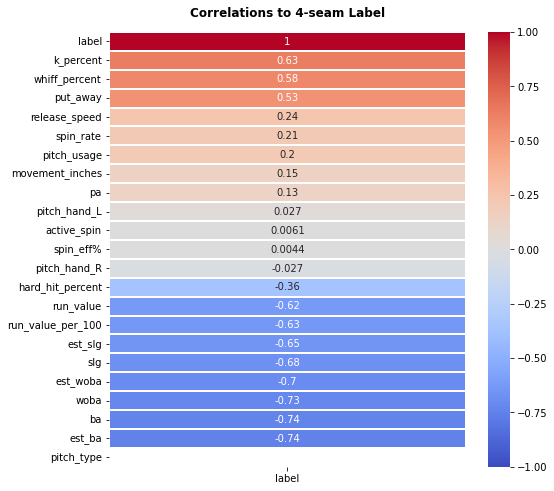

In [12]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_ff.corr()[['label']].sort_values(('label'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to 4-seam Label', fontweight = 'bold', pad = 15);

Positively correlated with label

Negatively correlated with lablel so the better the negatives the lower the run value / 100

In [13]:
X = X_ff.drop(columns = ['label'])
y = X_ff['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_ff = lr.predict(X_test)
pred_probs_ff = lr.predict_proba(X_test)[:,1]

print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.93
Test score: 0.91
Cross val score 0.9243


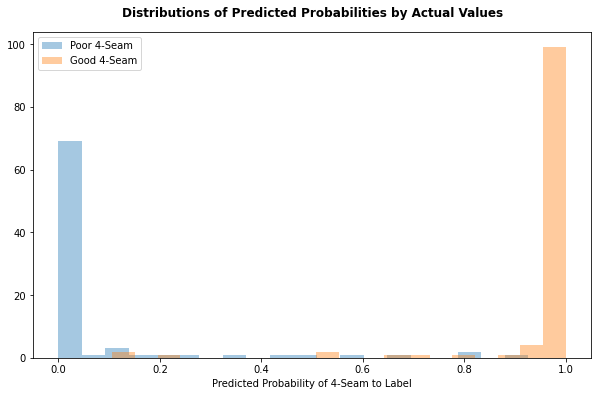

In [14]:
pred_ff_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_ff})
labels = ('Poor 4-Seam', 'Good 4-Seam')
plt.figure(figsize = (10, 6))
for group in pred_ff_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)
plt.xlabel('Predicted Probability of 4-Seam to Label')
plt.legend(labels)
plt.title('Distributions of Predicted Probabilities by Actual Values', fontweight = 'bold', pad = 15);

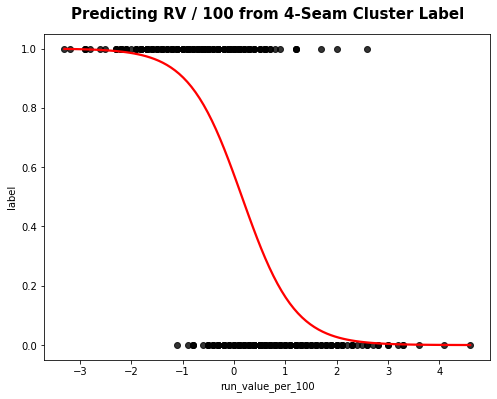

In [15]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_ff['run_value_per_100'], y = X_ff['label'], data = X_ff, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting RV / 100 from 4-Seam Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);

## Logistic Regression - Slider

### Heatmap of Features - Slider

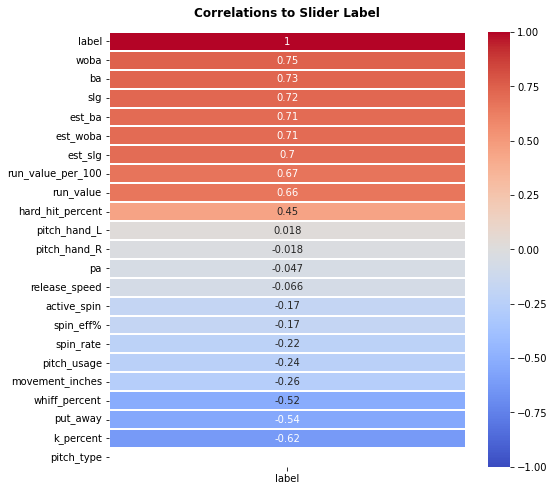

In [16]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_sl.corr()[['label']].sort_values(('label'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Slider Label', fontweight = 'bold', pad = 15);

In [17]:
X = X_sl.drop(columns = ['label'])
y = X_sl['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_sl = lr.predict(X_test)
pred_probs_sl = lr.predict_proba(X_test)[:,1]

print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.93
Test score: 0.92
Cross val score 0.9113


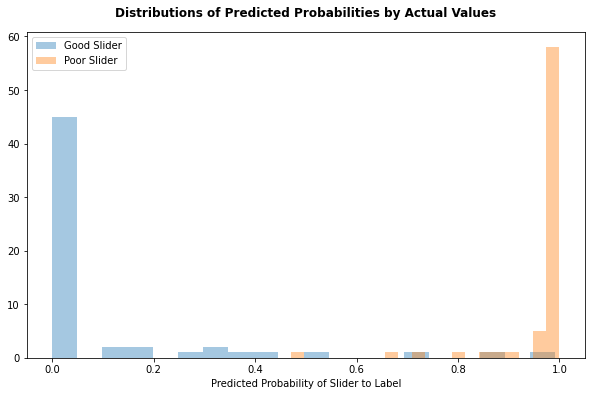

In [18]:
pred_sl_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_sl})
labels = ('Good Slider', 'Poor Slider')
plt.figure(figsize = (10, 6))
for group in pred_sl_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)
plt.xlabel('Predicted Probability of Slider to Label')
plt.legend(labels)
plt.title('Distributions of Predicted Probabilities by Actual Values', fontweight = 'bold', pad = 15);

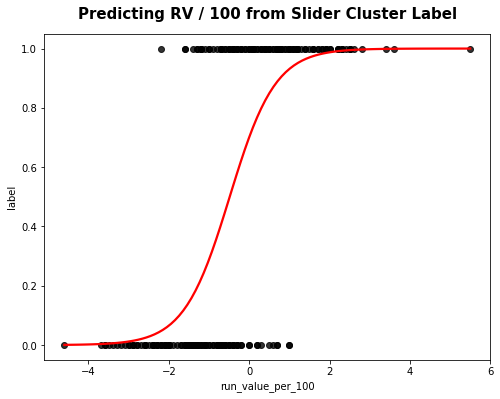

In [19]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_sl['run_value_per_100'], y = X_sl['label'], data = X_sl, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting RV / 100 from Slider Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);

## Logistic Regression - Changeup

### Heatmap of Features - Changeup

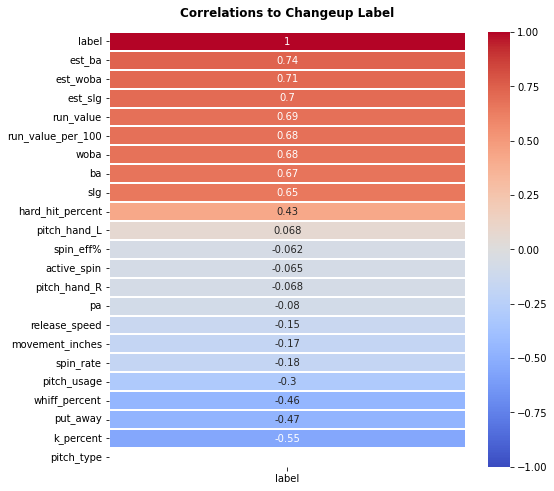

In [20]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_ch.corr()[['label']].sort_values(('label'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Changeup Label', fontweight = 'bold', pad = 15);

In [21]:
X = X_ch.drop(columns = ['label'])
y = X_ch['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_ch = lr.predict(X_test)
pred_probs_ch = lr.predict_proba(X_test)[:,1]

print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.96
Test score: 0.9
Cross val score 0.8813


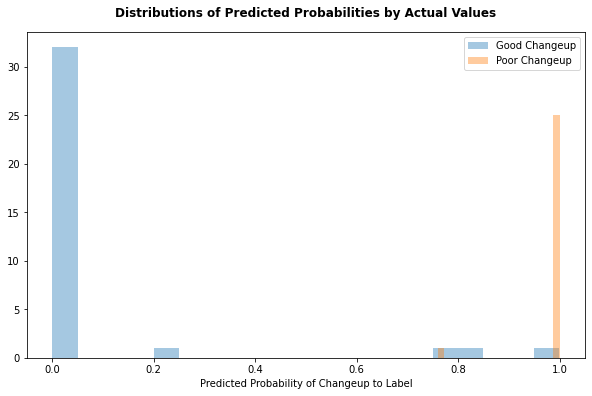

In [22]:
pred_ch_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_ch})
labels = ('Good Changeup', 'Poor Changeup')
plt.figure(figsize = (10, 6))
for group in pred_ch_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)
plt.xlabel('Predicted Probability of Changeup to Label');
plt.legend(labels)
plt.title('Distributions of Predicted Probabilities by Actual Values', fontweight = 'bold', pad = 15);

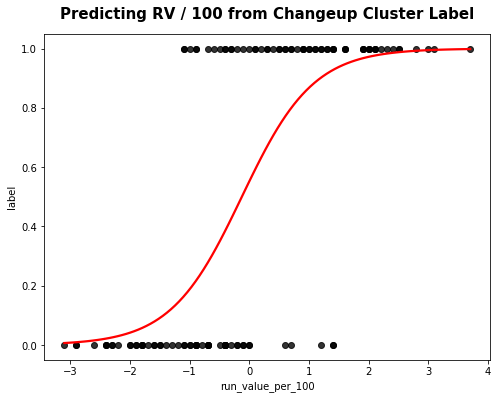

In [23]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_ch['run_value_per_100'], y = X_ch['label'], data = X_ch, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting RV / 100 from Changeup Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);

## Logistic Regression - Cutter

### Heatmap of Features - Cutter

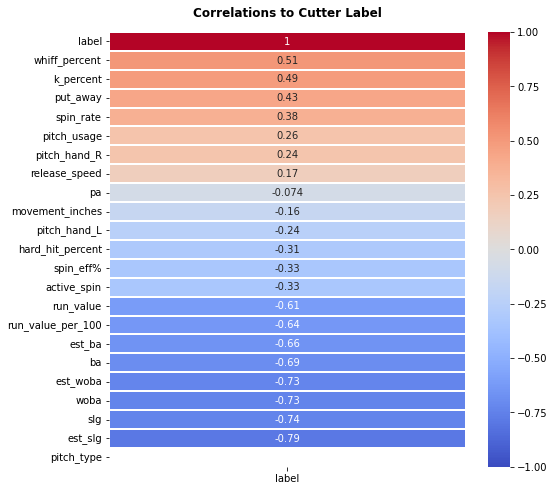

In [24]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_fc.corr()[['label']].sort_values(('label'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Cutter Label', fontweight = 'bold', pad = 15);

In [25]:
X = X_fc.drop(columns = ['label'])
y = X_fc['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_fc = lr.predict(X_test)
pred_probs_fc = lr.predict_proba(X_test)[:,1]

print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 1.0
Test score: 0.7
Cross val score 0.8833


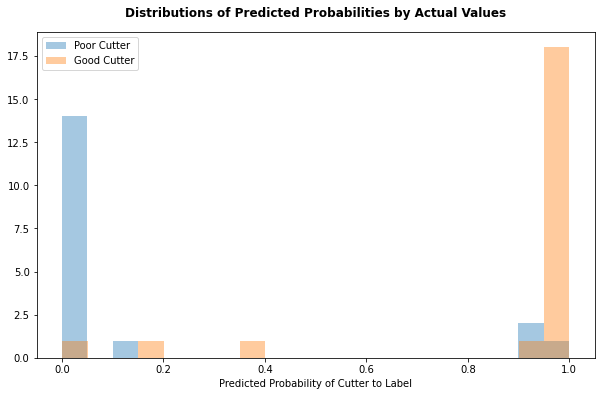

In [26]:
pred_fc_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_fc})
labels = ('Poor Cutter', 'Good Cutter')
plt.figure(figsize = (10, 6))
for group in pred_fc_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)
plt.xlabel('Predicted Probability of Cutter to Label')
plt.legend(labels)
plt.title('Distributions of Predicted Probabilities by Actual Values', fontweight = 'bold', pad = 15);

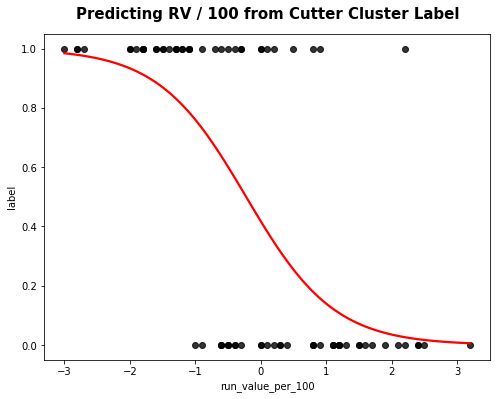

In [27]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_fc['run_value_per_100'], y = X_fc['label'], data = X_fc, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting RV / 100 from Cutter Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);